In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import os
os.chdir('/users/alex/Desktop/資料集/')
df = pd.read_csv('Stock_Daily_TW.txt', encoding = 'CP950', sep = '\t', low_memory=False, na_values=['       -'])
df.columns = ['ticker', 'name', 'date', 'open', 'high', 'low', 'close', 'volume', 'shares']

In [3]:
df['MV'] = df.close*df.shares

In [4]:
codelist = df[df.date==20180601]

In [5]:
codelist=codelist.sort_values(['MV'])
codelist=codelist.head(300)['ticker']

In [6]:
df = df.sort_values(['ticker', 'date'])

In [7]:
df.date = pd.Series(df.date, dtype='str')
df.date = pd.to_datetime(df.date )

## 整理成函數

In [8]:
def random_target(x,codelist, df):
  
    from matplotlib import dates

    target=codelist.take(np.random.permutation(len(codelist))[:1])
    Firm=target.values[0]
    
    aaa=df[df.ticker==Firm]
    target_date=aaa.take(np.random.permutation(len(aaa))[:1])
    
    limit=len(aaa)-61
    x=target_date.date.values[0]
    if x>aaa.date.values[limit]:
        
        while x<aaa.date.values[limit]:
            target_date=aaa.take(np.random.permutation(len(aaa))[:1])
            x=target_date.date.values[0]   
            
        begin_index=target_date.index[0]
        end_index=begin_index+60
        final=df.iloc[begin_index:end_index].copy()
 
    else:
        begin_index=target_date.index[0]
        end_index=begin_index+60
        final=df.iloc[begin_index:end_index].copy()
        
    final['num_date'] = final.date.apply(dates.date2num).values
    final = final[['ticker','date','num_date', 'open', 'high', 'low', 'close']].as_matrix()

    
    return final

In [64]:
def data_candlestick_array(input_array):
    data = input_array[:, 2:7]
    weekday_quotes = [tuple([i]+list(data[1:])) for i,data in enumerate(data)]

    from matplotlib.finance import candlestick_ohlc

    fig,ax = plt.subplots()
    fig.set_figwidth(3)
    fig.set_figheight(1.5)
    fig.subplots_adjust(bottom=0.1)



    candlestick_ohlc(ax, weekday_quotes, width=0.3, colordown='#4dff4d', colorup='#ff471a')
    plt.axis('off')

    fig.canvas.draw()

    # grab the pixel buffer and dump it into a numpy array
    pixel_array = np.array(fig.canvas.renderer._renderer)
    pixel_array = pixel_array[:,:,0:3]
    plt.close(fig)
    return pixel_array

In [69]:
import multiprocessing
import time
 
start = time.clock()
emp_list = list(range(1,5000)) 
dataset_list = map(lambda x: random_target(x,codelist,df), emp_list)
dataset_list = list(dataset_list)

if __name__ == '__main__':
    pool = multiprocessing.Pool()
    img_array = pool.map(data_candlestick_array, dataset_list)
    



Process ForkPoolWorker-35:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Process ForkPoolWorker-34:
Traceback (most recent call last):
  File "/Users/alex/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/alex/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/alex/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/alex/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/alex/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/alex/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/alex/anaconda3/lib/python3.6/multiprocessing/process.py", l

In [71]:
len(img_array)

4999

In [74]:
import pickle
with open("candlestick_array.txt", "wb") as f:
    pickle.dump(img_array, f)

In [76]:
with open("candlestick_array.txt", "rb") as f:
    img_array = pickle.load(f)

In [ ]:
train_data = np.array(img_array)

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np

input_img = Input(shape=(108, 216, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((3, 3), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((3, 3))(x)
decoded = Conv2D(3, (3, 3), activation='softmax', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')




In [142]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 108, 216, 3)       0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 108, 216, 8)       224       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 54, 108, 8)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 54, 108, 4)        292       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 27, 54, 4)         0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 27, 54, 4)         148       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 9, 18, 4)          0         
__________

In [86]:
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data, train_data, test_size=0.33, random_state=42)


x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


In [144]:
autoencoder.fit(x_train, x_train,
                epochs=4,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 3349 samples, validate on 1650 samples
Epoch 1/4
3349/3349 [==============================] - 128s 38ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 2/4
3349/3349 [==============================] - 123s 37ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 3/4
3349/3349 [==============================] - 135s 40ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 4/4
3349/3349 [==============================] - 123s 37ms/step - loss: 0.0132 - val_loss: 0.0132


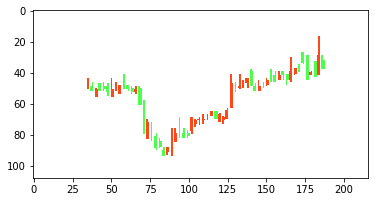

In [145]:
ax = plt.subplot(111)
plt.imshow(x_train[1])


In [146]:
decoded_imgs = autoencoder.predict(x_train)

In [152]:
fig =plt.gcf()
DPI = fig.get_dpi()

In [153]:
DPI

72.0

In [ ]:
fig = gcf()
DPI = fig.get_dpi()
fig.set_size_inches(2400.0/float(DPI),1220.0/float(DPI))

In [154]:
input_array

NameError: name 'input_array' is not defined

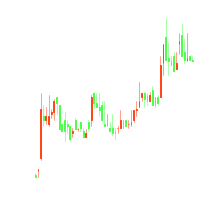

In [159]:
data = dataset_list[1][:, 2:7]
weekday_quotes = [tuple([i]+list(data[1:])) for i,data in enumerate(data)]

from matplotlib.finance import candlestick_ohlc

fig,ax = plt.subplots()
DPI = fig.get_dpi()
fig.set_size_inches(224.0/float(DPI),224.0/float(DPI))
fig.subplots_adjust(bottom=0.1)



candlestick_ohlc(ax, weekday_quotes, width=0.3, colordown='#4dff4d', colorup='#ff471a')
plt.axis('off')

fig.canvas.draw()

# grab the pixel buffer and dump it into a numpy array
pixel_array = np.array(fig.canvas.renderer._renderer)
pixel_array = pixel_array[:,:,0:3]
#plt.close(fig)

In [160]:
pixel_array.shape

(224, 224, 3)